# 0.0 Libraries

In [34]:
import pandas as pd
import inflection
import math
import calendar
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1.0 Data

## 1.1 Functions

## 1.2 Loading Data

In [3]:
#raw data
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#joinning/merge
df_store_sales = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_store_sales.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
222127,243,2,2015-01-13,9874,1204,1,1,0,0,a,a,310.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
315599,817,3,2014-10-08,22940,3136,1,1,0,0,a,a,140.0,3.0,2006.0,0,NaN,NaN,NaN
119574,270,3,2015-04-15,9625,1277,1,1,0,0,a,a,1450.0,7.0,2014.0,0,NaN,NaN,NaN
308537,203,3,2014-10-15,7005,981,1,0,0,0,c,c,490.0,11.0,2002.0,0,NaN,NaN,NaN
28918,1044,1,2015-07-06,5329,775,1,0,0,0,c,a,240.0,4.0,2015.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


## 1.3 Data Overview

### 1.3.1 Renaming Columns

In [5]:
df1 = df_store_sales.copy()

In [6]:
cols_old = list(df_store_sales.columns)
snakecase = lambda x: inflection.underscore(x)
#new col names
cols_new = list(map(snakecase, cols_old))
cols_new

['store',
 'day_of_week',
 'date',
 'sales',
 'customers',
 'open',
 'promo',
 'state_holiday',
 'school_holiday',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'promo_interval']

In [7]:
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.3.2 Data Dimensions


In [8]:
print('# of rows: {}'.format(df1.shape[0]))
print('# of columns: {}'.format(df1.shape[1]))

# of rows: 1017209
# of columns: 18


### 1.3.3 Data Types

In [9]:
# changing Date from object to date
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.3.4 Checking NA's

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.3.5 Filling NA's thinking about the business

In [11]:
df1['competition_distance'].max()

75860.0

In [12]:
# CompetitionDistance - no competition nearby or distance is so high we can ignore it            
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)



In [13]:
# CompetitionOpenSinceMonth - no competition or we don't know the date
# I'm using the same value as the column date to fill this NA (first iteration)    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1 )



In [14]:
# CompetitionOpenSinceYear     
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1 )



In [15]:
# Promo2SinceWeek - NA = stopped promo  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)



In [16]:
# Promo2SinceYear    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)



In [17]:
# PromoInterval - shows the months promo was active
month_map = {}
for m in range(1,13):
    month_map[m] = str(calendar.month_name[m])[0:3] 

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
        

In [18]:
df1.sample(5).T

,597990,1005668,839978,800993,948033
store,21,724,54,94,1069
day_of_week,6,5,6,6,1
date,2014-01-11 00:00:00,2013-01-11 00:00:00,2013-06-08 00:00:00,2013-07-13 00:00:00,2013-03-04 00:00:00
sales,5016,6557,8833,5259,11198
customers,563,689,861,523,1208
open,1,1,1,1,1
promo,0,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,d,d,d,a


In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 1.3.6 Checking data types after df manipulation

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
#promo2_since_week and year are floats and can be changed to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [22]:
#competition_since_month and year are floats and can be changed to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

In [23]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.3.7 Descriptive Statistics

In [24]:
#grouping columns - numerical and categorical
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.3.7.1 Numerical Attributes

In [25]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skw, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenating dataframes
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index() #metrics

In [26]:
m.columns = ['attributes', 'min', 'max', 'range', 'neab', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,neab,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


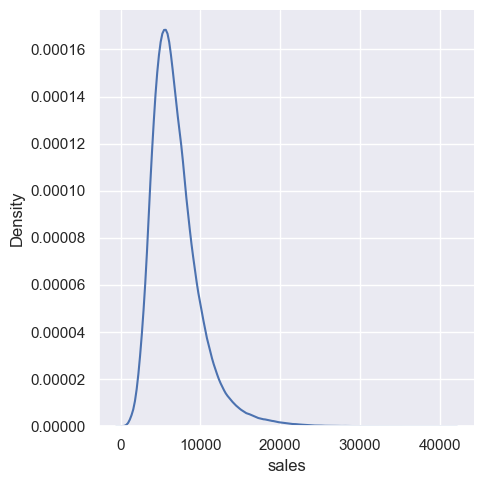

In [52]:
plt.fig 
sns.set_theme()
df2 = df1[df1['sales']!=0]

sns.displot(df2['sales'], kind='kde')


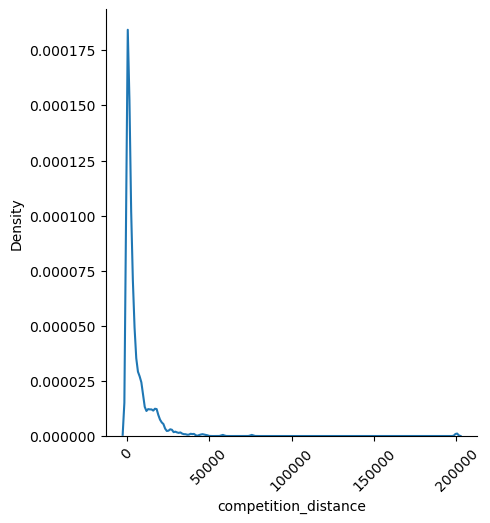

In [39]:
fig, ax = plt.subplots
sns.displot(df2['competition_distance'], kind='kde')
plt.xticks(rotation=45);

#### 1.3.7.2 Categorical Attributes

In [28]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [29]:
df1[df1['sales'] == 0].shape

(172871, 20)

### 1.2.1